# Wine aroma prediction using Vision Transformer
Here will be used Vision Transformer to predict wine aroma from the previously obtained wine composition matrices

In [1]:
#Import the necessary libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTForImageClassification
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import average_precision_score

from tqdm import tqdm

C:\Users\Peach\AppData\Local\Temp\ipykernel_23312\1427776762.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 1. Working with data
At this stage, Load the previously prepared data, and process the data for further neural networking 

In [2]:
# Loading data
X_array =  np.load('X_array.npy')
Y_array =  np.load('Y_array.npy')

In [3]:
# Separation of data into training, validation and test data in the ratio of 70:20:10
X_train, X_test, y_train, y_test = train_test_split(X_array, Y_array, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [4]:
# Conversion to a tensor
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_val = torch.tensor(X_val)
y_val = torch.tensor(y_val)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

In [5]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))

323
323
81
81
45
45


Since Vision Transformer has been trained on 224x224 images, need to bring images to the same size by padding (adding white pixels in equal proportions to the bottom, top and sides of the image), a method chosen to preserve chemical information without distorting it through interpolation

In [6]:
# Create a custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        # Add channels if there are none (i.e. if the images have dimension [N, H, W]).
        if x.dim() == 3:  
            x = x.unsqueeze(1)  # Add channel dimensionality [N, 1, H, W]

        self.x = self.pad_to_224(x)  # Adding padding
        self.y = y

    def pad_to_224(self, x):
        padded_images = []
        for img in x:
            # Check that the input images are of size [1, 44, 100]
            _, h, w = img.shape
            assert h == 44 and w == 100, "Incorrect size of the input image"

            # Applying padding
            img_padded = TF.pad(img, (62, 90), fill=255)  # white background

            padded_images.append(img_padded)

        return torch.stack(padded_images)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Create Dataset and DataLoader
dataset_train = CustomDataset(X_train, y_train)
dataset_val = CustomDataset(X_val, y_val)
dataset_test = CustomDataset(X_test, y_test)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)


In [7]:
for x, y in dataloader_train:
    print(x.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([3, 1, 224, 224])


## 3. Loading of the pre-trained model and its additional training
At this stage will load the pre-trained model, change the necessary parameters, and retrain it on data

In [ ]:
def accuracy(logits, labels, threshold=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    return (preds == labels).float().mean().item()

In [ ]:
@torch.no_grad()
def eval_acc_vit(model, loader, device, threshold=0.5):
    model.eval()
    s, n = 0.0, 0
    for x, y in loader:
        x, y = x.to(device).float(), y.to(device).float()
        out = model(x)  # ImageClassifierOutput
        s += accuracy(out.logits.cpu(), y.cpu(), threshold)
        n += 1
    return s / max(1, n)

@torch.no_grad()
def per_sample_accuracy_vit(model, loader, device, threshold=0.5):
    model.eval()
    vals = []
    for x, y in loader:
        x, y = x.to(device).float(), y.to(device).float()
        out = model(x)
        probs = torch.sigmoid(out.logits)
        preds = (probs > threshold).float()
        acc_sample = (preds == y).float().mean(dim=1)  # [B]
        vals.append(acc_sample.cpu().numpy())
    return np.concatenate(vals, axis=0)

In [ ]:
def bootstrap_mean_std(values, n_boot=2000, seed=42):
    rng = np.random.default_rng(seed)
    values = np.asarray(values, dtype=float)
    n = len(values)
    boot_means = [values[rng.integers(0, n, size=n)].mean() for _ in range(n_boot)]
    return float(values.mean()), float(np.std(boot_means, ddof=1))

In [ ]:
@torch.no_grad()
def pr_auc_metrics_vit(model, loader, device):
    model.eval()
    Ys, Ps = [], []
    for x, y in loader:
        x, y = x.to(device).float(), y.to(device).float()
        out = model(x)
        Ys.append(y.cpu().numpy())
        Ps.append(torch.sigmoid(out.logits).cpu().numpy())
    Y = np.concatenate(Ys, axis=0)  # (N, C)
    P = np.concatenate(Ps, axis=0)  # (N, C)
    C = Y.shape[1]

    ap = np.full(C, np.nan, dtype=float)
    support = Y.sum(axis=0)
    for j in range(C):
        ap[j] = average_precision_score(Y[:, j], P[:, j]) if support[j] > 0 else np.nan

    try:
        micro_ap = average_precision_score(Y, P, average='micro')
        macro_ap = average_precision_score(Y, P, average='macro')
    except ValueError:
        micro_ap, macro_ap = np.nan, np.nan
    return ap, micro_ap, macro_ap

In [ ]:
def build_vit_1ch_pretrained(num_labels=10, model_name="google/vit-base-patch16-224",
                             freeze_encoder=True, unfreeze_last=0):

    model = ViTForImageClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        ignore_mismatched_sizes=True
    )
    model.config.problem_type = "multi_label_classification"

    old_proj = model.vit.embeddings.patch_embeddings.projection  
    hidden   = old_proj.out_channels
    new_proj = nn.Conv2d(
        in_channels=1,
        out_channels=hidden,
        kernel_size=old_proj.kernel_size,
        stride=old_proj.stride,
        padding=old_proj.padding,
        bias=False
    )
    with torch.no_grad():
        new_proj.weight.copy_(old_proj.weight.mean(dim=1, keepdim=True))
    model.vit.embeddings.patch_embeddings.projection = new_proj

    model.config.num_channels = 1

    if hasattr(model.vit.embeddings.patch_embeddings, "num_channels"):
        model.vit.embeddings.patch_embeddings.num_channels = 1

    if freeze_encoder:
        for p in model.vit.parameters():
            p.requires_grad = False
        for p in model.classifier.parameters():
            p.requires_grad = True
        if unfreeze_last > 0:
            layers = model.vit.encoder.layer
            for blk in layers[-unfreeze_last:]:
                for p in blk.parameters():
                    p.requires_grad = True
            for p in model.vit.layernorm.parameters():
                p.requires_grad = True
    return model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_splits   = 5
num_epochs = 15          
batch_size = 32
threshold  = 0.5
seed       = 42
lr_head    = 2e-4       

In [ ]:
class_names = ["Flowers","Chocolate/Cacao","Coffee","Nuts","Fruits",
               "Citrus","Berries","Wood","Tobacco/Smoke","Herbs and spices"]

In [ ]:
full_train = CustomDataset(X_train, y_train)   
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

cv_accs = []
cv_ap_all, cv_micro_all, cv_macro_all = [], [], []

for fold, (tr_idx, va_idx) in enumerate(kf.split(range(len(full_train))), 1):
    print(f"\n==== Fold {fold}/{n_splits} ====")
    ds_tr = Subset(full_train, tr_idx)
    ds_va = Subset(full_train, va_idx)
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,  num_workers=0)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, num_workers=0)

    model = build_vit_1ch_pretrained(num_labels=10, freeze_encoder=True, unfreeze_last=0).to(device)
    opt_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(opt_params, lr=lr_head, betas=(0.9, 0.999), weight_decay=1e-4)
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        for x, y in tqdm(dl_tr, leave=False, desc=f"Fold {fold} Ep {epoch+1}/{num_epochs}"):
            x, y = x.to(device).float(), y.to(device).float()
            assert x.dim() == 4 and x.size(1) == 1, f"Ожидается [B,1,H,W], получено {tuple(x.shape)}"
            optimizer.zero_grad(set_to_none=True)
            with autocast(True):
                out = model(x)  
                loss = nn.functional.binary_cross_entropy_with_logits(out.logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()

    val_acc = eval_acc_vit(model, dl_va, device, threshold)
    ap_fold, micro_auc, macro_auc = pr_auc_metrics_vit(model, dl_va, device)
    print(f"VAL Acc: {val_acc:.4f}  |  PR-AUC micro={micro_auc:.3f}  macro={macro_auc:.3f}")

    cv_accs.append(val_acc)
    cv_ap_all.append(ap_fold)
    cv_micro_all.append(micro_auc)
    cv_macro_all.append(macro_auc)

    del model, optimizer, scaler
    torch.cuda.empty_cache()

cv_acc_mean, cv_acc_std = float(np.mean(cv_accs)), float(np.std(cv_accs, ddof=1))
cv_ap_mat  = np.vstack(cv_ap_all)                       # (K, C)
cv_ap_mean = np.nanmean(cv_ap_mat, axis=0)              # (C,)
cv_ap_std  = np.nanstd(cv_ap_mat,  axis=0, ddof=1)
cv_micro_mean = float(np.nanmean(cv_micro_all))
cv_micro_std  = float(np.nanstd(cv_micro_all, ddof=1))
cv_macro_mean = float(np.nanmean(cv_macro_all))
cv_macro_std  = float(np.nanstd(cv_macro_all, ddof=1))

print(f"\nCV Accuracy: {cv_acc_mean:.3f} ± {cv_acc_std:.3f}")
print(f"CV PR-AUC Micro: {cv_micro_mean:.3f} ± {cv_micro_std:.3f}")
print(f"CV PR-AUC Macro: {cv_macro_mean:.3f} ± {cv_macro_std:.3f}")

## 4. Final Model

In [ ]:
dataset_full    = CustomDataset(X_train, y_train)
dataloader_full = DataLoader(dataset_full, batch_size=batch_size, shuffle=True)

dataset_test    = CustomDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

final_vit = build_vit_1ch_pretrained(num_labels=10, freeze_encoder=True, unfreeze_last=0).to(device)
opt_params = [p for p in final_vit.parameters() if p.requires_grad]
optimizer  = torch.optim.AdamW(opt_params, lr=lr_head, betas=(0.9, 0.999), weight_decay=1e-4)
scaler     = GradScaler()

for epoch in range(num_epochs):
    final_vit.train()
    for x, y in tqdm(dataloader_full, leave=False, desc=f"Final ViT Ep {epoch+1}/{num_epochs}"):
        x, y = x.to(device).float(), y.to(device).float()
        assert x.dim() == 4 and x.size(1) == 1, f"Ожидается [B,1,H,W], получено {tuple(x.shape)}"
        optimizer.zero_grad(set_to_none=True)
        with autocast(True):
            out = final_vit(x)
            loss = nn.functional.binary_cross_entropy_with_logits(out.logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()

test_acc_sample = per_sample_accuracy_vit(final_vit, dataloader_test, device, threshold)
test_acc_mean, test_acc_std = bootstrap_mean_std(test_acc_sample, n_boot=2000, seed=42)
test_ap, test_micro_auc, test_macro_auc = pr_auc_metrics_vit(final_vit, dataloader_test, device)

print(f"\nTEST Accuracy: {test_acc_mean:.3f} ± {test_acc_std:.3f}")
print(f"TEST PR-AUC Micro: {test_micro_auc:.3f}")
print(f"TEST PR-AUC Macro: {test_macro_auc:.3f}")


df_pr_auc = pd.DataFrame({
    "Aroma class":        class_names,
    "CV PR-AUC (mean)":   np.round(cv_ap_mean, 3),
    "CV PR-AUC (std)":    np.round(cv_ap_std, 3),
    "Test PR-AUC":        np.round(test_ap, 3)
}).sort_values(by="CV PR-AUC (mean)", ascending=False).reset_index(drop=True)

print("\n=== Per-class PR-AUC (CV & Test) — ViT-B/16 1ch ===")
print(df_pr_auc.to_string(index=False))


==== Fold 1/5 ====


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Fold 1 Ep 1/15:   0%|                                                                            | 0/9 [00:00<?, ?it/s]C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is n

VAL Acc: 0.7250  |  PR-AUC micro=0.615  macro=0.374

==== Fold 2/5 ====


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Fold 2 Ep 1/15:   0%|                                                                            | 0/9 [00:00<?, ?it/s]C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is n

VAL Acc: 0.7073  |  PR-AUC micro=0.597  macro=0.367

==== Fold 3/5 ====


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Fold 3 Ep 1/15:   0%|                                                                            | 0/9 [00:00<?, ?it/s]C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is n

VAL Acc: 0.7469  |  PR-AUC micro=0.526  macro=0.316

==== Fold 4/5 ====


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Fold 4 Ep 1/15:   0%|                                                                            | 0/9 [00:00<?, ?it/s]C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is n

VAL Acc: 0.7844  |  PR-AUC micro=0.614  macro=0.300

==== Fold 5/5 ====


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Fold 5 Ep 1/15:   0%|                                                                            | 0/9 [00:00<?, ?it/s]C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is n

VAL Acc: 0.7797  |  PR-AUC micro=0.588  macro=0.332

CV Accuracy: 0.749 ± 0.034
CV PR-AUC Micro: 0.588 ± 0.036
CV PR-AUC Macro: 0.338 ± 0.032


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Final ViT Ep 1/15:   0%|                                                                        | 0/11 [00:00<?, ?it/s]C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is n


TEST Accuracy (ViT-B/16 1ch): 0.762 ± 0.019
TEST PR-AUC Micro: 0.635
TEST PR-AUC Macro: 0.372

=== Per-class PR-AUC (CV & Test) — ViT-B/16 1ch ===
     Aroma class  CV PR-AUC (mean)  CV PR-AUC (std)  Test PR-AUC
          Citrus             0.704            0.054        0.842
         Flowers             0.590            0.066        0.699
            Nuts             0.569            0.109        0.650
Herbs and spices             0.361            0.096        0.401
          Fruits             0.312            0.041        0.234
            Wood             0.235            0.218        0.100
   Tobacco/Smoke             0.179            0.122        0.288
          Coffee             0.160            0.014        0.287
         Berries             0.152            0.083        0.173
 Chocolate/Cacao             0.118            0.039        0.048


## 5. PR-AUC Bars — Test Set

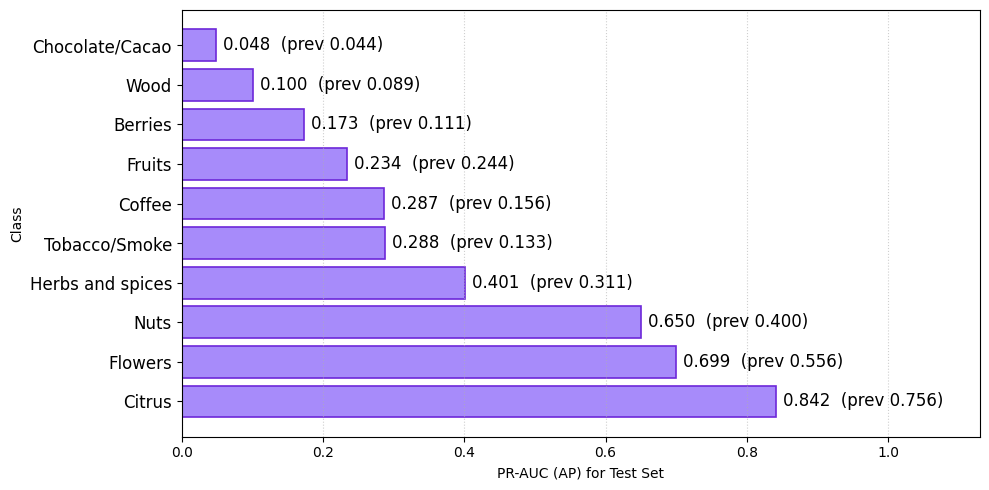

In [9]:
def plot_pr_auc_test(ap_values, class_names, y_test_tensor, savepath=None, show_lift=True):

    ap_values = np.asarray(ap_values, dtype=float)
    if hasattr(y_test_tensor, "cpu"):
        Yt = y_test_tensor.cpu().numpy()
    else:
        Yt = np.asarray(y_test_tensor)

    # Prevalence 
    prev = np.nanmean(Yt, axis=0).astype(float)

    ap_safe = np.copy(ap_values)
    ap_sort_key = np.where(np.isnan(ap_safe), -1.0, ap_safe)

    order = np.argsort(-ap_sort_key)
    ap_sorted   = ap_values[order]
    prev_sorted = prev[order]
    names_sorted = [class_names[i] for i in order]

    y_pos = np.arange(len(ap_sorted))

    fig, ax = plt.subplots(figsize=(10, max(4, 0.5 * len(ap_sorted))))

    bars = ax.barh(y_pos, np.nan_to_num(ap_sorted, nan=0.0),
                   color="#a78bfa", edgecolor="#6d28d9", lw=1.2)
    ax.set_xlim(0, 1.13)
    ax.set_xlabel("PR-AUC (AP) for Test Set", fontsize=10)
    ax.set_ylabel("Class")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names_sorted, fontsize=12)
    ax.grid(axis="x", linestyle=":", alpha=0.6)

    for bar, apv, pv in zip(bars, ap_sorted, prev_sorted):
        y = bar.get_y() + bar.get_height() / 2
        x_text = min((0.0 if np.isnan(apv) else apv) + 0.01, 0.98)
        label = f"{apv:.3f}"
        if show_lift:
        ax.text(x_text, y, label, va="center", fontsize=12)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()

plot_pr_auc_test(test_ap, class_names, y_test, savepath=None, show_lift=True)